In [ ]:
import numpy as np
import random
import logging
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, OneHotCategorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Helpers

In [ ]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Model

In [ ]:
class MixtureDensityNetwork(nn.Module):

    def __init__(self, dim_in, dim_out, n_components):
        super().__init__()
        self.pi_network = CategoricalNetwork(dim_in, n_components)
        self.normal_network = MixtureDiagNormalNetwork(dim_in, dim_out,
                                                       n_components)

    def forward(self, x):
        return self.pi_network(x), self.normal_network(x)

    def loss(self, x, y):
        pi, normal = self.forward(x)
        loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=2)
        loss = -torch.logsumexp(pi.logits + loglik, dim=1)
        return loss

    def sample(self, x):
        pi, normal = self.forward(x)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples

    def weights(self, x):
        pi, normal = self.forward(x)
        loglik = normal.log_prob(x.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=2)
        weights = pi.probs*torch.clip(loglik.exp(), max=1.)
        return weights

In [ ]:
class MixtureDiagNormalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, n_components, hidden_dim=None):
        super().__init__()
        self.n_components = n_components
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 2 * out_dim * n_components),
        )

    def forward(self, x):
        params = self.network(x)
        mean, sd = torch.split(params, params.shape[1] // 2, dim=1)
        mean = torch.stack(mean.split(mean.shape[1] // self.n_components, 1))
        sd = torch.stack(sd.split(sd.shape[1] // self.n_components, 1))
        return Normal(mean.transpose(0, 1), (F.elu(sd)+1+1e-7).transpose(0, 1))

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        params = self.network(x)
        return OneHotCategorical(logits=params)

Neural Data

In [ ]:
def summarize(data):
    print(f'number of trials: {len(data)}')
    
    seq_lens = [len(seq) for seq in data]
    print(f'spike sequence length range: {min(seq_lens)} ~ {max(seq_lens)}')
    
    ranges = []
    for i in range(4):
        start = min([seq[0, i]  for seq in data])
        end   = max([seq[-1, i] for seq in data])
        ranges.append((start, end))

    print(f'time range (sec): {ranges[0][0]:.3f} ~ {ranges[0][1]:.3f}')
    print(f'x range:   {ranges[1][0]:.3f} ~ {ranges[1][1]:.3f}')
    print(f'z range:   {ranges[2][0]:.3f} ~ {ranges[2][1]:.3f}')
    print(f'amp range:   {ranges[3][0]:.3f} ~ {ranges[3][1]:.3f}')

In [ ]:
spike_indices = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/unsorted/unsorted_spike_indices.npy')
spike_features = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/unsorted/unsorted_spike_features.npy')
start_movement_times = np.load("drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_start_movement.npy")
np1_channel_map = np.load('drive/MyDrive/Neural/ibl/np1_channel_map.npy')
behavior_tasks = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/sorted/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_feature.npy')
choices = behavior_tasks[:,:,:,22:24].sum(2)[0,:,:]
n_trials = start_movement_times.shape[0]

In [ ]:
# (spike time, x, z, amp)
data = np.concatenate([spike_indices[:,0].reshape(-1,1), spike_features[:,[0,2,4]]], axis = 1)

In [ ]:
all_trials = []
for n in range(n_trials):
    trial = data[(data[:,0] >= start_movement_times[n]-30003.0003*0.5) & (data[:,0] <= start_movement_times[n]+30003.0003),:]
    trial[:,0] = (trial[:,0] - trial[:,0].min()) / 30003.0003
    all_trials.append(trial)

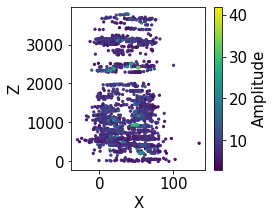

In [ ]:
# Inspect a single trial
idx = 0
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams.update({'font.size': 15})
plt.scatter(all_trials[idx][:,1], all_trials[idx][:,2], c=all_trials[idx][:,3], s=5),
plt.xlabel("X")
plt.ylabel("Z")
plt.colorbar(label="Amplitude");

In [ ]:
summarize(all_trials)

number of trials: 286
spike sequence length range: 2134 ~ 3578
time range (sec): 0.000 ~ 1.500
x range:   -13.195 ~ 76.024
z range:   -5.847 ~ 3786.594
amp range:   4.112 ~ 35.244


In [ ]:
logging.basicConfig(level='info')
logger = logging.getLogger(__name__)

class DisableLogger():
    def __enter__(self):
       logging.disable(logging.CRITICAL)
    def __exit__(self, exit_type, exit_value, exit_traceback):
       logging.disable(logging.NOTSET)

In [ ]:
x = all_trials[0][:,1:]
norm_x = ( x - x.mean(0, keepdims=True)) / x.std(0, keepdims=True)
norm_x =  torch.Tensor(norm_x)

In [ ]:
model = MixtureDensityNetwork(3, 3, n_components=50)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.99, 0.999))

In [ ]:
for i in range(2000):
    optimizer.zero_grad()
    loss = model.loss(norm_x, norm_x).mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)
    optimizer.step()
    if i % 100 == 0:
        logger.info(f"Iter: {i}\t" + f"Loss: {loss.data:.2f}")

In [ ]:
samples = model.sample(norm_x)

In [ ]:
norm_x[:5]

tensor([[ 0.3474,  2.1169, -0.7866],
        [-1.1752,  1.6203,  0.5378],
        [-1.0577,  1.5612,  0.4536],
        [ 1.0159, -0.2298, -0.3399],
        [-1.1724,  0.8460,  3.9601]])

In [ ]:
samples[:5]

tensor([[ 0.4053,  2.0817, -0.8136],
        [-1.2065,  1.6367,  0.5460],
        [-1.2760,  1.9209,  0.1798],
        [ 1.0136, -0.2279, -0.3442],
        [-1.1796,  0.8088,  3.9354]])

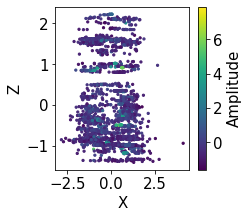

In [ ]:
with DisableLogger():
  logger.disabled = True
  plt.rcParams["figure.figsize"] = (3,3);
  plt.rcParams.update({'font.size': 15});
  plt.scatter(norm_x[:,0], norm_x[:,1], c=norm_x[:,2], s=5);
  plt.xlabel("X");
  plt.ylabel("Z");
  plt.colorbar(label="Amplitude");

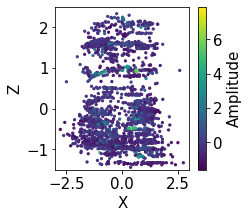

In [ ]:
with DisableLogger():
  plt.rcParams["figure.figsize"] = (3,3)
  plt.rcParams.update({'font.size': 15})
  plt.scatter(samples[:,0], samples[:,1], c=samples[:,2], s=5),
  plt.xlabel("X")
  plt.ylabel("Z")
  plt.colorbar(label="Amplitude");
  plt.xlim([-3, 3]);
  plt.ylim([-1.5, 2.5]);

In [ ]:
weights = model.weights(norm_x)
# pi, _ = model.forward(norm_x)
# weights = pi.probs

Visualizations

In [ ]:
n_time_bins = 30
t_bins = torch.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
ts = torch.tensor(all_trials[0][:,0])
masks = [(torch.bucketize(ts, t_bins, right=False)-1 == idx) for idx in range(n_time_bins)]
binned_weights = torch.stack([(masks[idx].reshape(-1,1).repeat(1, weights.shape[1]) * weights) for idx in range(n_time_bins)]).sum(1).transpose(1,0)

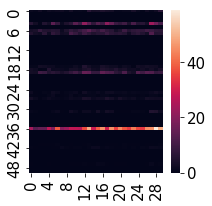

In [ ]:
with DisableLogger():
  sns.heatmap(binned_weights.detach().numpy())
  plt.show()

In [ ]:
pi, _ = model.forward(norm_x)
labels = pi.probs.argmax(1)

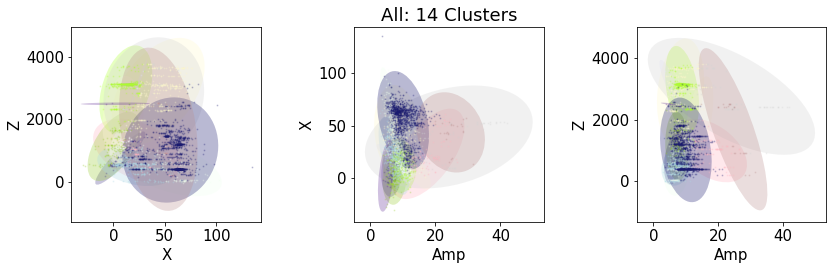

In [ ]:
with DisableLogger():
  plt.rcParams["figure.figsize"] = (12,4)
  plt.rcParams.update({'font.size': 15})
  fig, axes = plt.subplots(1, 3) 

  all_colors = [k for k,v in pltc.cnames.items()]
  random.shuffle(all_colors)

  # Only have 148 colors so ...
  # for i in range(len(np.unique(labels))):
  for i in range(148):
      confidence_ellipse(x[labels == i, 0], x[labels == i, 1], axes[0], alpha=0.3, facecolor=all_colors[i], edgecolor=None, zorder=0)
      axes[0].scatter(x[labels == i][:5000,0], x[labels == i][:5000,1], s=1, alpha=0.2, c=all_colors[i])
      axes[0].set_xlabel('X')
      axes[0].set_ylabel('Z')

      confidence_ellipse(x[labels == i, 2], x[labels == i, 0], axes[1], alpha=0.3, facecolor=all_colors[i], edgecolor=None, zorder=0)
      axes[1].scatter(x[labels == i][:5000,2], x[labels == i][:5000,0], s=1, alpha=0.2, c=all_colors[i])
      axes[1].set_xlabel('Amp')
      axes[1].set_ylabel('X')
      axes[1].set_title('All: {} Clusters'.format(len(np.unique(labels))))

      confidence_ellipse(x[labels == i, 2], x[labels == i, 1], axes[2], alpha=0.3, facecolor=all_colors[i], edgecolor=None, zorder=0)
      axes[2].scatter(x[labels == i][:5000,2], x[labels == i][:5000,1], s=1, alpha=0.2, c=all_colors[i])
      axes[2].set_xlabel('Amp')
      axes[2].set_ylabel('Z')

  plt.tight_layout()
  plt.show()

To do:
1. Implement 3D multivariate normal instead of three 1D independent normal.
2. Implement mini-batch SGD (with shared GMM basis).